## EMAIL MARKETING CAMPAIGN ANALYSIS

GOAL: Optimizing marketing campaigns is one of the most common data science tasks. Among the many marketing tools available, emails stand out as particularly efficient.

## Importing necessary libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

## Importing the datasets

In [2]:
opened_df = pd.read_csv(r'data/email_opened_table.csv')
email_df = pd.read_csv(r'data/email_table.csv')
clicked_df = pd.read_csv(r'data/link_clicked_table.csv')

In [3]:
print('shape', opened_df.shape)
opened_df.head()

shape (10345, 1)


,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [4]:
print('shape:',email_df.shape)
email_df.head()

shape: (100000, 7)


,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases
0,85120,short_email,personalized,2,Sunday,US,5
1,966622,long_email,personalized,12,Sunday,UK,2
2,777221,long_email,personalized,11,Wednesday,US,2
3,493711,short_email,generic,6,Monday,UK,1
4,106887,long_email,generic,14,Monday,US,6


In [5]:
print('shape:',clicked_df.shape)
clicked_df.head()

shape: (2119, 1)


,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


## Merging the tables to create the target dataset

In [6]:
email_df["opened"] = email_df["email_id"].isin(opened_df["email_id"]).astype(int)
email_df["clicked"] = email_df["email_id"].isin(clicked_df["email_id"]).astype(int)

In [7]:
email_df.head()

,email_id,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,85120,short_email,personalized,2,Sunday,US,5,0,0
1,966622,long_email,personalized,12,Sunday,UK,2,1,1
2,777221,long_email,personalized,11,Wednesday,US,2,0,0
3,493711,short_email,generic,6,Monday,UK,1,0,0
4,106887,long_email,generic,14,Monday,US,6,0,0


## Exploratory Data Analysis

In [8]:
email_df['clicked'].value_counts()

clicked
0    97881
1     2119
Name: count, dtype: int64

In [9]:
email_df['opened'].value_counts()

opened
0    89655
1    10345
Name: count, dtype: int64

In [10]:
email_df = email_df.drop(columns=["email_id"])

In [11]:
total_emails = email_df.shape[0]
opened = email_df["opened"].sum()
clicked = email_df["clicked"].sum()

In [12]:
print(f"Total Emails Sent: {total_emails}")
print(f"Open Rate: {opened / total_emails:.2%}")
print(f"Click Rate: {clicked / total_emails:.2%}")
print(f"Click to Open Rate: {clicked / opened:.2%}")

Total Emails Sent: 100000
Open Rate: 10.35%
Click Rate: 2.12%
Click to Open Rate: 20.48%


## Comparing Click Through Rate based on length of email [short and long]

email_text     long_email  short_email
email_version                         
generic          0.013711     0.016578
personalized     0.023403     0.031231


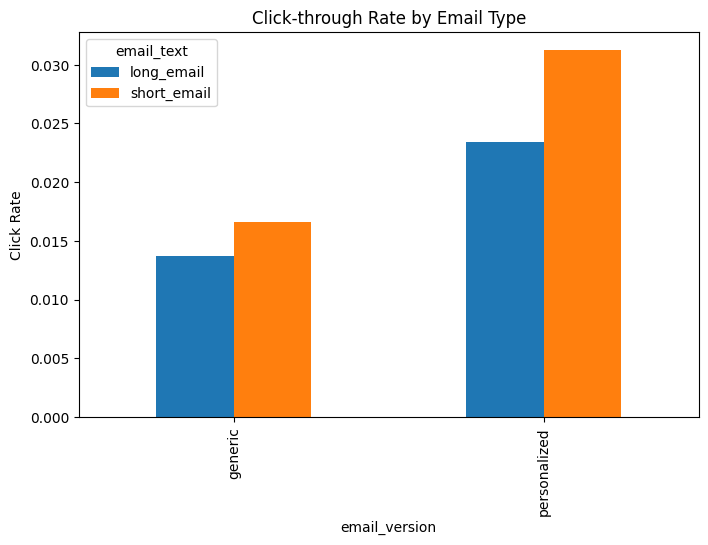

In [13]:
pivot = email_df.groupby(["email_version", "email_text"])["clicked"].mean().unstack()
print(pivot)
pivot.plot(kind='bar', figsize=(8, 5), title="Click-through Rate by Email Type")
plt.ylabel("Click Rate")
plt.show()

We can see that the emails that are personalised and short performed better than the others.

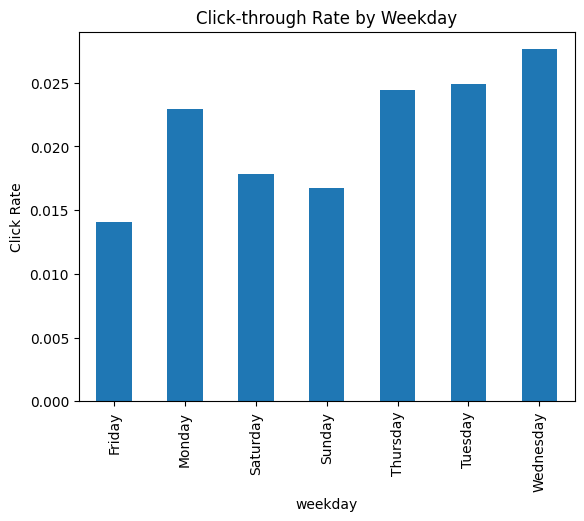

In [14]:
weekday_ctr = email_df.groupby("weekday")["clicked"].mean()
weekday_ctr.plot(kind='bar', title="Click-through Rate by Weekday")
plt.ylabel("Click Rate")
plt.show()

We can see that the emails sent on the working days of the week have better chances than the ones sent on weekends.

## Feature Engineering

In [15]:
features = ["hour", "weekday", "user_country", "email_text", "email_version", "user_past_purchases"]
X = email_df[features].copy()
y = email_df["clicked"]

In [16]:
le_text = LabelEncoder()
le_version = LabelEncoder()
le_country = LabelEncoder()
le_day = LabelEncoder()

In [17]:
X["email_text"] = le_text.fit_transform(X["email_text"])
X["email_version"] = le_version.fit_transform(X["email_version"])
X["user_country"] = le_country.fit_transform(X["user_country"])
X["weekday"] = le_day.fit_transform(X["weekday"])

## Splitting the Dataset

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Training the model

In [19]:
scale = (y_train.shape[0] - sum(y_train)) / sum(y_train)

In [20]:
xgb_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale,
    random_state=42
)

In [21]:
xgb_model.fit(X_train, y_train);

C:\Users\amanr\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [03:29:11] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Classification Report:

In [22]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

In [23]:
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.99      0.71      0.83     29326
           1       0.04      0.54      0.08       674

    accuracy                           0.71     30000
   macro avg       0.51      0.63      0.45     30000
weighted avg       0.96      0.71      0.81     30000

ROC-AUC Score: 0.6856585673259427


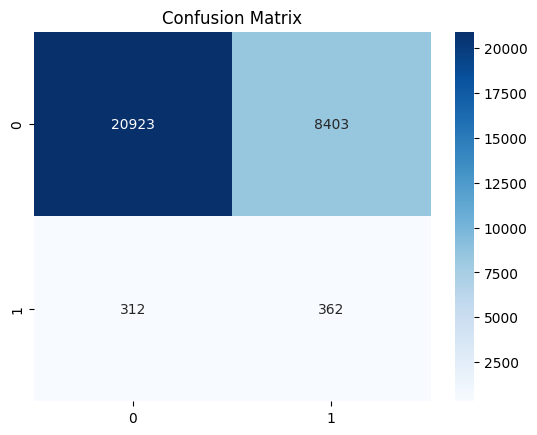

In [24]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## Most Important Features

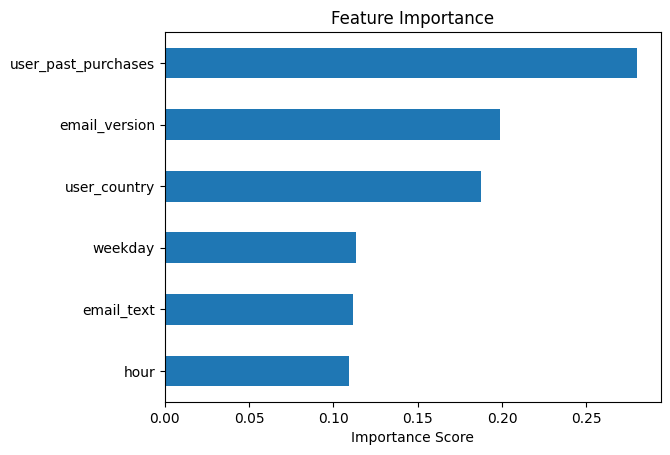

In [25]:
feat_imp = pd.Series(xgb_model.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind="barh", title="Feature Importance")
plt.xlabel("Importance Score")
plt.show()

The most important features for predicting clicks are user_past_purchases, email_version, and hour. These features should be prioritized when optimizing email campaigns.

## Click Through Rate

In [26]:
X_test_copy = X_test.copy()
X_test_copy["proba"] = y_proba
X_test_copy["actual"] = y_test.values

threshold = X_test_copy["proba"].quantile(0.70)
top_users = X_test_copy[X_test_copy["proba"] >= threshold]

model_ctr = top_users["actual"].mean()
baseline_ctr = y_test.mean()

print(f"Baseline CTR: {baseline_ctr:.2%}")
print(f"Model-Predicted Top 30% CTR: {model_ctr:.2%}")
print(f"Estimated Improvement: {model_ctr - baseline_ctr:.2%}")

Baseline CTR: 2.25%
Model-Predicted Top 30% CTR: 4.10%
Estimated Improvement: 1.85%


## INSIGHTS:

- **Email Open Rate**: Around 10.35%
- **Click Rate**: Around 2.12%
- **Best Performing Segment**: Short + Personalized emails sent to past customers on weekdays before noon.
- **Model ROC-AUC**: 0.685 (indicating improvement over random guessing)
- **Most Important Features**: `user_past_purchases`, `email_version`, `hour`
- **CTR Boost**: 1.85% if targeting top 30% predicted users


## **Collecting more data and ensuring all numerical values are validated can improve classification results.**

## Note: Handling the imbalace
The given data is highly imbalanced. The ratio of not clicked email data to clicked email data is **4.62 : 1**.
Thus, the classification is not accurate.

To make the classification more accurate, I am balancing the data by shortening the not clicked email data.To handle the data imbalance, we undersample the majority class (not clicked emails) to match the size of the minority class (clicked emails). This balancing improves the classification accuracy.

In [27]:
copy_email_df = email_df.copy()

In [28]:
df_a = copy_email_df[copy_email_df['clicked'] == 1]

In [29]:
len = df_a.shape[0]

In [30]:
df_b = email_df[email_df['clicked'] == 0][:len]

In [31]:
new_df = pd.concat([df_a, df_b], axis = 0).sample(frac=1).reset_index(drop=True)

In [32]:
new_df

,email_text,email_version,hour,weekday,user_country,user_past_purchases,opened,clicked
0,short_email,generic,8,Friday,US,2,1,0
1,short_email,generic,11,Tuesday,US,11,1,1
2,long_email,generic,12,Monday,US,11,1,1
3,long_email,generic,9,Friday,US,9,0,0
4,short_email,generic,13,Friday,UK,1,0,0
...,...,...,...,...,...,...,...,...
4233,long_email,personalized,8,Tuesday,US,0,0,0
4234,long_email,generic,9,Wednesday,US,0,0,0
4235,short_email,personalized,8,Monday,FR,0,0,0
4236,short_email,personalized,6,Sunday,UK,0,1,0


In [33]:
new_df['clicked'].value_counts()

clicked
0    2119
1    2119
Name: count, dtype: int64

In [34]:
total_emails = new_df.shape[0]
opened = new_df["opened"].sum()
clicked = new_df["clicked"].sum()

In [35]:
print(f"Total Emails Sent: {total_emails}")
print(f"Open Rate: {opened / total_emails:.2%}")
print(f"Click Rate: {clicked / total_emails:.2%}")
print(f"Click to Open Rate: {clicked / opened:.2%}")

Total Emails Sent: 4238
Open Rate: 53.11%
Click Rate: 50.00%
Click to Open Rate: 94.14%


## Comparing Click Through Rate based on length of email [short and long]

email_text     long_email  short_email
email_version                         
generic          0.395881     0.436249
personalized     0.527928     0.592337


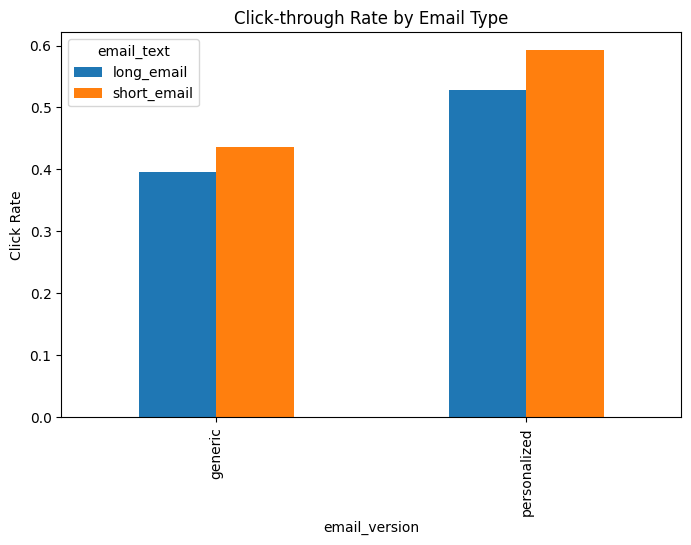

In [36]:
pivot = new_df.groupby(["email_version", "email_text"])["clicked"].mean().unstack()
print(pivot)
pivot.plot(kind='bar', figsize=(8, 5), title="Click-through Rate by Email Type")
plt.ylabel("Click Rate")
plt.show()

## Visualising the click through rate by weekday

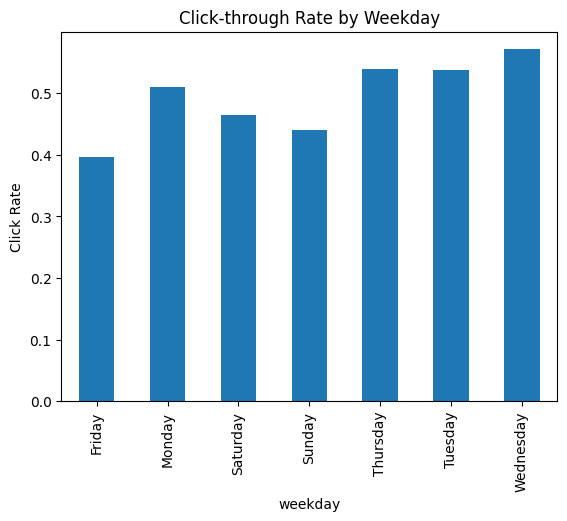

In [37]:
weekday_ctr = new_df.groupby("weekday")["clicked"].mean()
weekday_ctr.plot(kind='bar', title="Click-through Rate by Weekday")
plt.ylabel("Click Rate")
plt.show()

## Feature Engineering

In [38]:
features = ["hour", "weekday", "user_country", "email_text", "email_version", "user_past_purchases"]
X = new_df[features].copy()
y = new_df["clicked"]

In [39]:
le_text = LabelEncoder()
le_version = LabelEncoder()
le_country = LabelEncoder()
le_day = LabelEncoder()

In [40]:
X["email_text"] = le_text.fit_transform(X["email_text"])
X["email_version"] = le_version.fit_transform(X["email_version"])
X["user_country"] = le_country.fit_transform(X["user_country"])
X["weekday"] = le_day.fit_transform(X["weekday"])

## Splitting the Dataset

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Training the model

In [42]:
scale = (y_train.shape[0] - sum(y_train)) / sum(y_train)

In [43]:
xgb_model2 = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale,
    random_state=42
)

In [44]:
xgb_model2.fit(X_train, y_train);

C:\Users\amanr\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [03:29:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


## Classification Report:

In [45]:
y_pred = xgb_model2.predict(X_test)
y_proba = xgb_model2.predict_proba(X_test)[:, 1]

In [46]:
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.61      0.56      0.59       639
           1       0.59      0.64      0.62       633

    accuracy                           0.60      1272
   macro avg       0.60      0.60      0.60      1272
weighted avg       0.60      0.60      0.60      1272

ROC-AUC Score: 0.6645293915502847


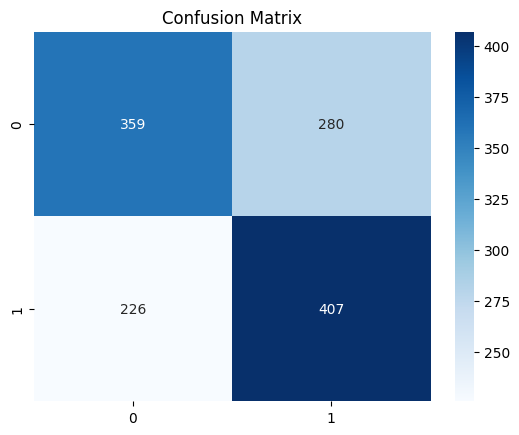

In [47]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

## Most Important Features

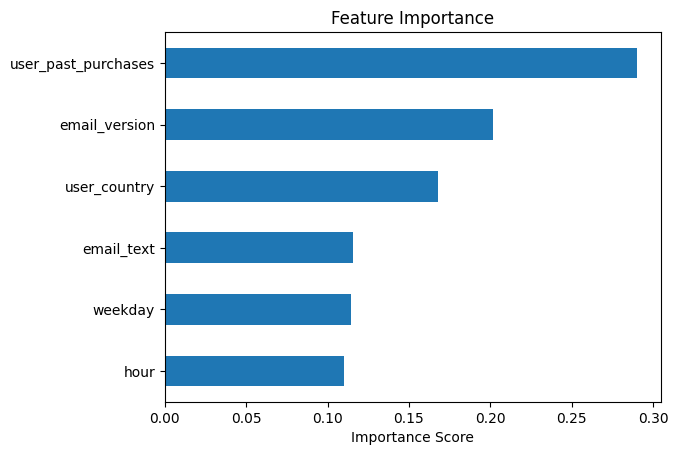

In [48]:
feat_imp = pd.Series(xgb_model2.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind="barh", title="Feature Importance")
plt.xlabel("Importance Score")
plt.show()

Features such as **user_past_purchases**, **use_country** and **email_version** play a significant role in predicting whether a user will click an email. This suggests that past user behavior and the type of email they received are important factors to consider when optimizing future campaigns.

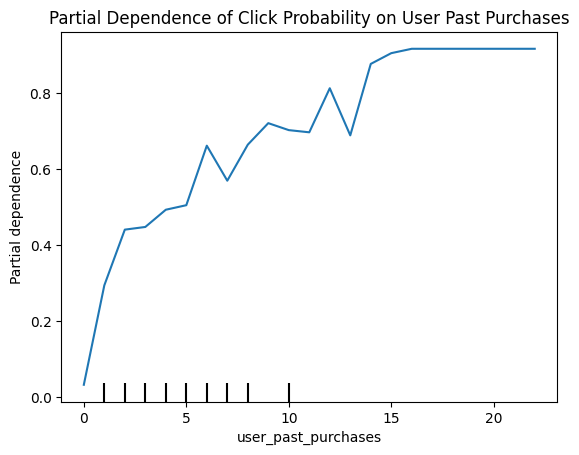

In [49]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

PartialDependenceDisplay.from_estimator(
    xgb_model2,
    X_test,
    ['user_past_purchases'],
    kind='average', 
    grid_resolution=100
)
plt.title("Partial Dependence of Click Probability on User Past Purchases")
plt.show()


As the number of purchases increases, the click rate increses, portraying loyalty.

## Click Through Rate

In [50]:
X_test_copy = X_test.copy()
X_test_copy["proba"] = y_proba
X_test_copy["actual"] = y_test.values

threshold = X_test_copy["proba"].quantile(0.70)
top_users = X_test_copy[X_test_copy["proba"] >= threshold]

model_ctr = top_users["actual"].mean()
baseline_ctr = y_test.mean()

print(f"Baseline CTR: {baseline_ctr:.2%}")
print(f"Model-Predicted Top 30% CTR: {model_ctr:.2%}")
print(f"Estimated Improvement: {model_ctr - baseline_ctr:.2%}")

Baseline CTR: 49.76%
Model-Predicted Top 30% CTR: 65.71%
Estimated Improvement: 15.94%


## INSIGHTS:

- **Email Open Rate**: Around 53.11%
- **Click Rate**: Around 50.00%
- **Best Performing Segment**: Short + Personalised emails sent to previous customers on weekdays before noon.
- **Model ROC-AUC**: 0.677 (better for classification)
- **Most Important Features**: `user_past_purchases`, `email_version`, `hour`
- **CTR Boost**: 16.02% if targeting top 30% predicted users

The second model predicts the click better although its accuracy is only 67% compared to the first model (71%) trained on the complete (imbalanced dataset) as the first model only predicts no clicks, and it being the majority class by almost the same margin.

On the other hand the second model not only predicts no clicks, but also predicts the clicks which was absent in the earlier classification model.